# Analyse dsync Notebook

## Abstract

TODO

## Experiences

Les experiences on été mené sur 3 sessions *data-yyyy-mm-dd* à chaque session correspond une série d'expérience *n__d_yyyy_mm_dd_t_hh_mm_ss* 
Il y a 6 musiciens et chaque musicien participant à l'expérience on 2 dispositifs d'acquisition (**riots**), un toujours sur la tête et l'autre au bras ou à la jambe suivant la session. Il y a donc un total de 12 dispositifs d'acquisition dans une expérience.

Un dispositif d'acquisition dispose de :

* 3 capteurs  : accelerometre (**acc**) gyroscope (**gyro**) et magnetometre (**mag**) sur 3 axes chacun
* 3 metrics : 
  * **orientation** sur 3 axes, angle du dispositif par rapport à l'axe de gravitation
  * acceleration filtré (**accfilt**) sur 3 axes, filtre passe bas (~10 Hz) pour les données de l'accelerometre pour éliminer les micro variations indésirable
  * **intensity**, normalisation de la quantité de mouvement, représentation "adouci" du mouvement enregistré

Il y a donc au total 16 metrics par dispositif par musicien.

un fichier son  de la performance, suivant la session il inclu le son d'un metronome

une vidéo de la performance

un fichier *riots-musicians.txt* qui assoscie chaque riot à un musicien ainsi que son type 

Une session comprend aussi des enrigistrement de calibration, des improvisations et des tests

## Datas

Stocké au format *.txt* pour chaque riots, échantilloné à 10ms, les données comprennent :

| Time Stamp | acc_x | acc_y | acc_z | gyro_x | gyro_y | gyro_z | mag_x | mag_y | mag_z | orientation_x | orientation_y | orientation_z | accfilt_x | accfilt_y | accfilt_z | intensity |
| ---------- | ----- | ----- | ----- | ------ | ------ | ------ | ----- | ----- | ----- | ------------- | ------------- | ------------- | --------- | --------- | --------- | --------- |

Les données doivent être tronqué dans le temps car elles comprennes des données biaisé avant et après la performance.

## Code 

### Imports

* [pandas](https://pandas.pydata.org/) Pour manipulé des ensemble de donnée avec des DataFrame
* [matplotlib]() pour la visualisation de donnée
* [seaborn]() pour réaliser des graphs plus fancy
* TODO

In [1]:
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

import os
import re
import glob

import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets 
import pickle

### Data structures

Les structures de données doivent avoir une organisation scalable, optimisé pour éviter les redondances et pour accélérer la recherche, la structure est "trivial" pour les autres language de programmation plus bas niveau
Les structures de données peuvent s'organiser comme suit :

* class Session:
    * date: string (date)
    * experiences: dict of Experience

* class Experience:
    * time: string (time)
    * number: int
    * musician_riots: dictionary { musician: (riot_head, riot_limb) }
    * riots: dict of Riot (avant list)

* class Riot:
    * dataset: dict Dataset (avant list)
    * duration : float
    * trunc: (start: float, end: float)
    * riot_type: "arm" | "leg" | "head"

* class Dataset:
    * t: float
    * acc_x: float
    * acc_y: float
    * acc_z: float
    * gyro_x: float
    * gyro_y: float
    * gyro_z: float
    * mag_x: float
    * mag_y: float
    * mag_z: float
    * orientation_x: float
    * orientation_y: float
    * orientation_z: float
    * accfilt_x: float
    * accfilt_y: float
    * accfilt_z: float
    * intensity: float

In [2]:
class Session:
    def __init__(self, date, experiences=None):
        self.date = date
        if(experiences is None):
            experiences = {}
        self.experiences = experiences

class Experience:
    def __init__(self, time, number,musician_riots={}, riots=None):
        self.time = time
        self.number = number
        # WARNING : Mutable default argument, all instance of experience point on the same instance of musician_riots dictionnary
        self.musician_riots = musician_riots
        if(riots is None):
            riots = {}
        self.riots = riots
        self.trunc = (0,0)

class Riot:
    def __init__(self, dataset, duration, riot_type):
        self.dataset = dataset
        self.duration = duration
        # trunc into experiences instead in riots
        # self.trunc = trunc
        self.riot_type = riot_type

class Dataset:
    def __init__(self, t, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, orientation_x, orientation_y, orientation_z, accfilt_x, accfilt_y, accfilt_z, intensity):
        self.t = t
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.orientation_x = orientation_x
        self.orientation_y = orientation_y
        self.orientation_z = orientation_z
        self.accfilt_x = accfilt_x
        self.accfilt_y = accfilt_y
        self.accfilt_z = accfilt_z
        self.intensity = intensity
        
    def __str__(self):
        return f"t: {self.t}, acc_x: {self.acc_x}, acc_y: {self.acc_y}, acc_z: {self.acc_z}, gyro_x: {self.gyro_x}, gyro_y: {self.gyro_y}, gyro_z: {self.gyro_z}, mag_x: {self.mag_x}, mag_y: {self.mag_y}, mag_z: {self.mag_z}, orientation_x: {self.orientation_x}, orientation_y: {self.orientation_y}, orientation_z: {self.orientation_z}, accfilt_x: {self.accfilt_x}, accfilt_y: {self.accfilt_y}, accfilt_z: {self.accfilt_z}, intensity: {self.intensity}"


### Datas loading

peut être le faire en C pour accélérer le programme

In [3]:
# import os
# import re
# import glob

def load_data(session_folder):
    # Extract date from folder name
    date = session_folder.split('-',1)[-1]
    session = Session(date)
    
    musicians_info_path = os.path.join(session_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    # Charger les infos des musiciens et des riots
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)-1] = (musician, riot_type)
            
           # Vérifier si le musicien est déjà dans le dictionnaire
            if musician not in musician_riots:
                # Initialiser un tuple pour 'head' et 'arm/leg' avec None
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                # Mettre à jour le numéro de riot pour 'head'
                musician_riots[musician] = (int(riot_number)-1, musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                # Mettre à jour le numéro de riot pour 'arm/leg' si ce n'est pas déjà fait
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)
    
    # Charger les données des expériences
    for exp_file in glob.glob(f'{session_folder}/*-data-riot-*.txt'):
        exp_info = os.path.basename(exp_file).split('_')
        exp_number = int(exp_info[0])
        exp_time = re.search(r't_(\d+_\d+_\d+)-data', exp_file).group(1).replace('_', ':')
        riot_number = int(exp_info[-1].split('.')[0].split('-')[-1]) - 1
        
        experience = None
        # print("exp",exp_number)
        if exp_number in session.experiences:
            experience = session.experiences[exp_number]
        else:
            experience = Experience(exp_time,exp_number)
            experience.musician_riots = musician_riots
            session.experiences[exp_number] = experience
        
        # Lecture des données du riot
        datasets = []
        with open(exp_file, 'r') as file:
            for line in file:
                data = list(map(float, line.strip().split()))
                dataset = Dataset(*data)
                datasets.append(dataset)
        
        # Calculer la durée comme le max de t
        duration = max([d.t for d in datasets])
        session.experiences[exp_number].trunc = (0,max(duration,session.experiences[exp_number].trunc[1]))
        
        riot = Riot(datasets, duration, musician_info[riot_number][1])
        session.experiences[exp_number].riots[riot_number] = riot
        
    return session


### Building Dataframe 

TODO

class Dataf (extend Dataset): 
  * exp_n: int
  * riot_n: int
  * musician: string
  * riot_type: "arm" | "leg" | "head"

In [4]:
class Dataf(Dataset):
    def __init__(self,dataset,exp_n,riot_n,musician,riot_type):
        Dataset.__init__(self,dataset.t,dataset.acc_x,dataset.acc_y,dataset.acc_z,dataset.gyro_x,dataset.gyro_y,dataset.gyro_z,dataset.mag_x,dataset.mag_y,dataset.mag_z,dataset.orientation_x,dataset.orientation_y,dataset.orientation_z,dataset.accfilt_x,dataset.accfilt_y,dataset.accfilt_z,dataset.intensity)
        self.exp_n = exp_n
        self.riot_n = riot_n
        self.musician = musician
        self.riot_type = riot_type

In [5]:
def session_to_dataf(session):
    # Construire les objets Dataf en prenant compte du tronquage
    datasetsf = []

    for exp in session.experiences:      
        experience = session.experiences[exp]
        for musician in list(experience.musician_riots.keys()):
            riot_head, riot_limb = experience.musician_riots[musician]
            datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type) for data in experience.riots[riot_head].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
            datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_limb].riot_type) for data in experience.riots[riot_limb].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    
    # Utilisation de l'introspection pour construire la liste des dictionnaires
    data_dicts = [vars(dataset) for dataset in datasetsf]

    # Création du DataFrame Pandas
    return pd.DataFrame(data_dicts)
            

### Exemple

Display waveform of the intensity of Cello over time in experience 10

In [ ]:
data_folder = "../data/"
session2_folder = data_folder + 'data-2023-09-27'

session = load_data(session2_folder)
df = session_to_dataf(session)

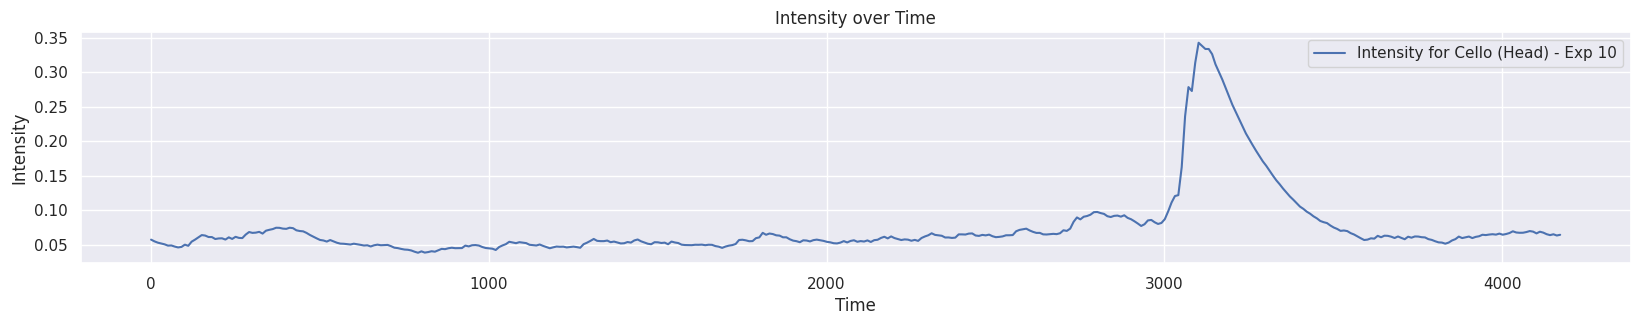

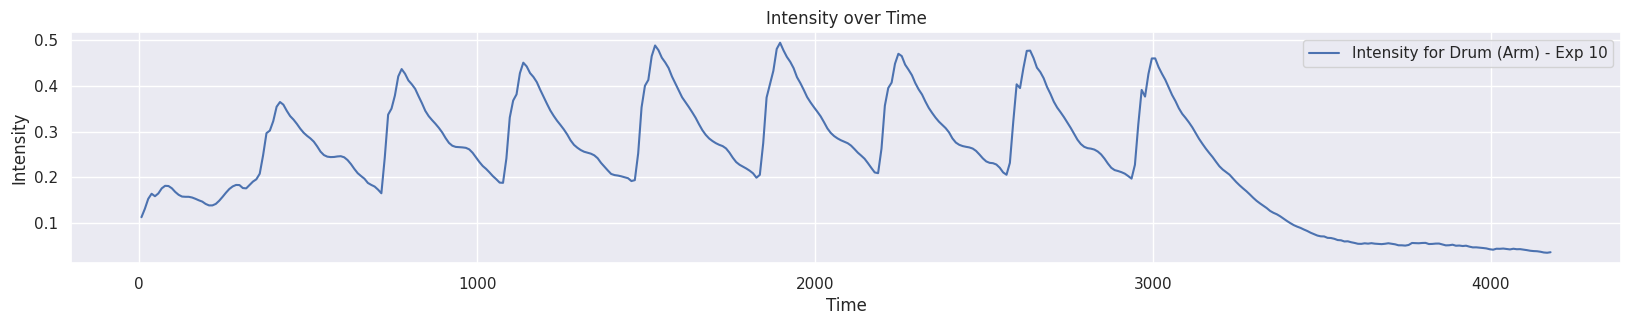

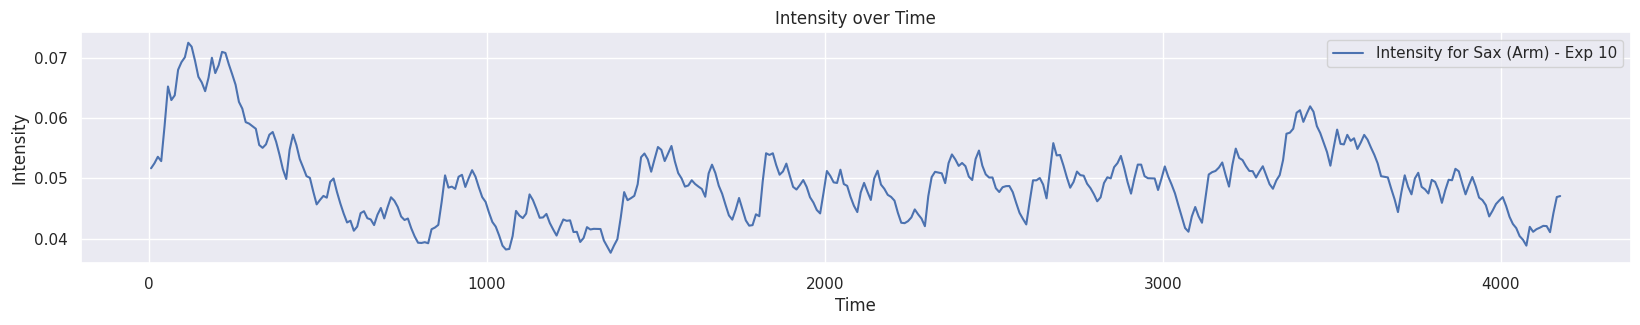

In [9]:
filtered_df_Cello = df[(df['musician'] == 'Cello') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Cello, x='t', y='intensity', label='Intensity for Cello (Head) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

filtered_df_Drum = df[(df['musician'] == 'Drum') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Drum, x='t', y='intensity', label='Intensity for Drum (Arm) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

filtered_df_Sax = df[(df['musician'] == 'Sax') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Sax (Arm) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# filtered_df_Piano = df[(df['musician'] == 'Piano') & (df['riot_type'] == 'arm') & (df['exp_n'] == 20)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Piano, x='t', y='intensity', label='Intensity for Piano (Arm) - Exp 20')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

### Make it interactive

TODO

In [6]:
%matplotlib widget

# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# from IPython.display import Audio, display
# from IPython.display import clear_output
# import ipywidgets as widgets
# import pickle

data_folder = "../data/"
cache_folder = "../data/cache/"
session_folder = ""
session = None
df = None
sound_file_path = ""
session_folders = []

# Sauvegarde

def save_session(session,str=''):
    with open('../data/cache/data-' + session.date + str + '.pickle', 'wb') as fichier:
        pickle.dump(session, fichier)
def load_session(session_path):
    with open(session_path, 'rb') as fichier:
        return pickle.load(fichier)
    return None

# Widgets
# Liste tous les dossiers dans data_folder
session_folders = [f.name for f in os.scandir(data_folder) if f.is_dir()]
session_select = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'] + session_folders,
    description='Sessions:',
    disabled=False
)
saved_folders = [f for f in os.listdir(cache_folder) if f.endswith('.pickle')]
saved_select = widgets.Dropdown(
    options=['Sélectionnez une sauvegarde de session'] + saved_folders,
    description='Saves:',
    disabled=False
)
sound_dropdown = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'],
    description='Fichiers son:',
    disabled=False,)

def update_sound_dropdown(session_folder):
    sound_files = [f for f in os.listdir(os.path.join(session_folder, 'sound')) if f.endswith('.aif')]
    if sound_files:
        sound_dropdown.options = sound_files
    else:
        sound_dropdown.options = ['Aucun fichier trouvé']

def on_session_change(change):
    global df
    global session
    global session_folder
    session_folder = os.path.join(data_folder, change['new'])
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    print("chargement du dataframe ...")
    session = load_data(session_folder)
    df = session_to_dataf(session)
    save_session(session)
    print("chargement du dataframe Terminé")
    
def on_saved_change(change):
    global df
    global session
    global session_folder
    
    print("chargement du dataframe ...")
    session = load_session(os.path.join(cache_folder, change['new']))
    df = session_to_dataf(session)
    save_session(session)
    print("chargement du dataframe Terminé")
    session_folder = os.path.join(data_folder,'data-'+session.date)
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)


def on_sound_change(change):
    global sound_file_path
    sound_file_path = change['new']
    setup_waveform_trunc(os.path.join(data_folder, session_folder,"sound",sound_file_path))

# Widgets callback
session_select.observe(on_session_change, names='value')
saved_select.observe(on_saved_change, names='value')
sound_dropdown.observe(on_sound_change, names='value')

# Widgets display
display(session_select,saved_select)
display(sound_dropdown)

# session2_sound_10 = session2_folder + '/sound/10__d_2023_27_09_t_12_41_47.aif'

# Pour tronquer la waveform

# Définir la fonction de lecture audio
def play_audio(start_time, end_time, audio, sr):
    display(Audio(data=audio[int(start_time * sr):int(end_time * sr)], rate=sr))

# Créer la fonction de mise à jour de la sélection
def update_selection(change):
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(start_end_slider.value[0], start_end_slider.value[1], color='red', alpha=0.5)
        plt.show()

# Créer la fonction pour configurer et afficher le waveform avec les contrôles
def setup_waveform_trunc(audio_path):
    global audio, sr, start_end_slider, play_button, out
    
    # Charger le fichier audio
    audio, sr = librosa.load(audio_path)
    
    # Créer les widgets pour contrôler la lecture et le tronquage
    start_end_slider = widgets.FloatRangeSlider(
        value=[0, len(audio)/sr], 
        min=0, 
        max=len(audio)/sr, 
        step=0.01, 
        description='Time Range (s):',
        continuous_update=False
    )
    play_button = widgets.Button(description="Play")
    trunc_button = widgets.Button(description="Trunc")
    out = widgets.Output()
    
    
    
    # Lier la mise à jour de la sélection aux changements de valeur des curseurs
    start_end_slider.observe(update_selection, names='value')

    # Lier la lecture à l'appui sur le bouton
    def on_play_button_clicked(b):
        play_audio(start_end_slider.value[0], start_end_slider.value[1], audio, sr)

    play_button.on_click(on_play_button_clicked)
    
    # Tronquage des datas
    
    def on_trunc_button_clicked(b):
        global df
        #Màj de l'objet session (attention sconde -> milliseconde)
        session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (start_end_slider.value[0] * 1000, start_end_slider.value[1] * 1000)
        # Màj du dataframe
        print("mis à jour du dataframe ...")
        df = session_to_dataf(session)
        save_session(session)
        print("mis à jour du dataframe Terminé")
    
    trunc_button.on_click(on_trunc_button_clicked)
    
    # Initialiser l'affichage
    with out:
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.show()
    
    # Afficher les widgets
    display(widgets.VBox([start_end_slider, play_button,trunc_button, out]))
    
    %matplotlib inline

Dropdown(description='Sessions:', options=('Sélectionnez un dossier de session', 'cache', 'data-2023-09-26', '…

Dropdown(description='Saves:', options=('Sélectionnez une sauvegarde de session', 'data-2023-09-27.pickle'), v…

Dropdown(description='Fichiers son:', options=('Sélectionnez un dossier de session',), value='Sélectionnez un …

chargement du dataframe ...
chargement du dataframe Terminé


dataframe mis à jour
chargement du dataframe ...


FileNotFoundError: [Errno 2] No such file or directory: '../data/cache/Sélectionnez une sauvegarde de session'

chargement du dataframe ...
chargement du dataframe Terminé


## Analysis

tempo dans le mouvement, wavelet pour les motifs de mouvement , autocorrélation , Fourier, analyse de spectre  

### Distribution of movement

D'abord analyser la distribution du mouvement (pour une expérience) par instrument peut nous donner un bon indicateur d'à quel point certain mouvement de même amplitude sont important durant la performance 
Plus tard il faudrait distinguer les mouvements spontannées des mouvements de couplage avec le tempo

TODO

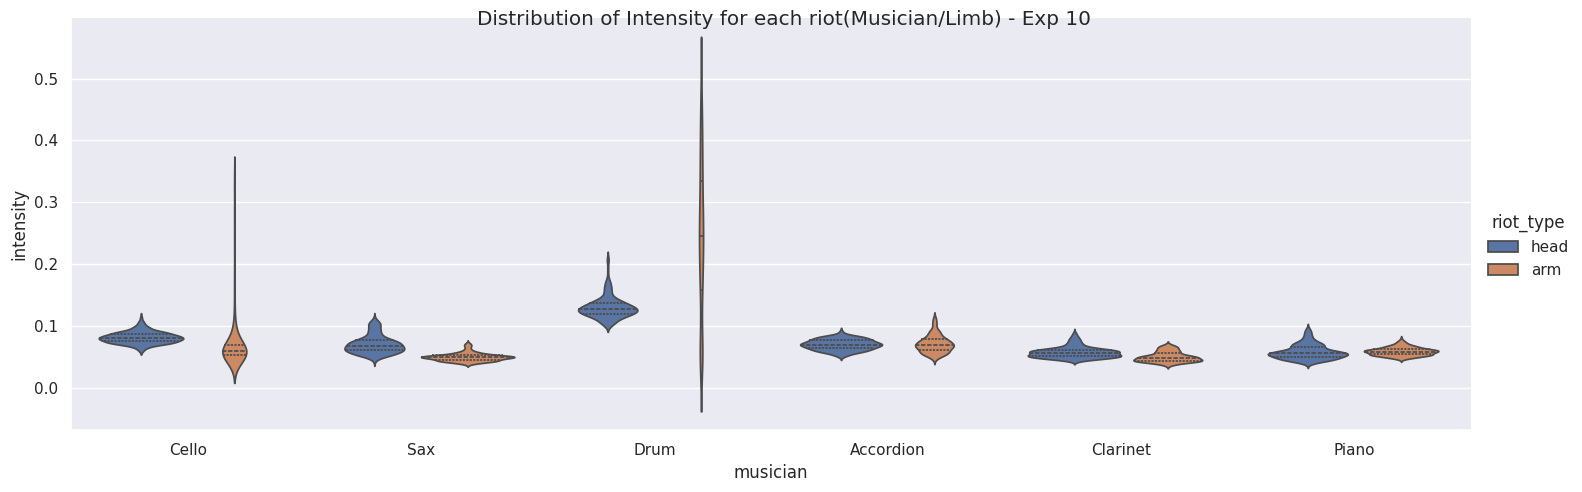

In [7]:
filtered_df_mvDistrib = df[(df['exp_n'] == 10)]

g = sns.catplot(
    # data=filtered_df_mvDistrib, x="musician", y="intensity", hue="riot_type",inner="quart" ,kind="violin",height=5,width=0.7,aspect=3,
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="riot_type",inner="quart" ,kind="violin",aspect=3,
)

# std_dev = filtered_df_mvDistrib.groupby(['musician', 'riot_type'])['intensity'].std().reset_index()
# h = sns.pointplot(data=std_dev, x='musician', y='intensity', hue='riot_type', dodge=True,
#               linestyle='none', markers='_', markersize=10,errorbar="ci", ax=g.ax)

# handles, labels = g.ax.get_legend_handles_labels()
# g.ax.legend(handles=handles, labels=labels)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()


In [ ]:
filtered_df_mvDistrib = df[(df['riot_type'] == "head")]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="exp_n",inner="quart" ,kind="violin",height=5,width=0.7,aspect=3,
)

std_dev = filtered_df_mvDistrib.groupby(['musician', 'riot_type'])['intensity'].std().reset_index()
h = sns.pointplot(data=std_dev, x='musician', y='intensity', hue='exp_n', dodge=True,
              linestyle='none', markers='_', markersize=10,errorbar="ci", ax=g.ax)

handles, labels = g.ax.get_legend_handles_labels()
g.ax.legend(handles=handles, labels=labels)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()

### Tempis


In [ ]:
# # plt.figure(figsize=(12,8))
# # Tgram = librosa.feature.tempogram(filtered_df_Cello['intensity'].to_numpy(), 100)
# # librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
# # plt.colorbar()
# # plt.title('Tempogram')
# # plt.show()
# import numpy as np


# signal = filtered_df_Cello['intensity'].to_numpy()
# # Normalisation du signal
# signal = signal - np.mean(signal)
# signal = signal / np.max(np.abs(signal))

# # Définir le taux d'échantillonnage
# sr = 100  # Le taux d'échantillonnage est de 100 Hz
# # tempo, _ = librosa.beat.beat_track(y=signal, sr=sr, tightness=100, trim=False)
# # Utiliser librosa.beat.tempo pour estimer le tempo global du signal
# # On utilise aggregate=None pour obtenir la distribution de tous les tempos estimés plutôt qu'un seul tempo global
# tempo_distribution = librosa.beat.tempo(y=signal, sr=sr, aggregate=None)

# # Visualiser la distribution du tempo
# plt.figure(figsize=(10, 6))
# plt.hist(tempo_distribution, bins=30, color='blue', alpha=0.7)
# plt.title('Distribution du Tempo')
# plt.xlabel('Tempo (battements par minute)')
# plt.ylabel('Fréquence')
# plt.show()

## TODO

* mettre au propre l'association riots musicien
* Enregistrer la structure de donnée
* Pouvoir Analyser en sélectionnant intéractivement (pour l'intensité d'abord)
* Tronquer les données desexpériences